# Homework08

Exercises to practice unsupervised learning with clustering

## Goals

- Get more practice with the ML flow: encode -> normalize -> train -> evaluate
- Understand the tradeoffs of modeling parameters
- Develop intuition for different clustering models and when to use them

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir
from PIL import Image as PImage

from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import KMeansClustering, GaussianClustering

from image_utils import get_pixels, make_image

## Helmet Sizing

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/PSAM-5020-2025S-A/WK02) and then again in [Homework06](https://github.com/PSAM-5020-2025S-A/Homework06).

This is the dataset that has anthropometric information about U.S. Army personnel.

#### WARNING

Like we mentioned in class, this dataset is being used for these exercises due to the level of detail in the dataset and the rigorous process that was used in collecting the data.

This is a very specific dataset and should not be used to draw general conclusions about people, bodies, or anything else that is not related to the distribution of physical features of U.S. Army personnel.

In [3]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

Let's load it into a `DataFrame`, like last week.

In [4]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


### Unsupervised Learning

Let's pretend we are designing next-generation helmets with embedded over-the-ear headphones and we want to have a few options for sizes.

We could use clustering to see if there is a number of clusters that we can divide our population into, so each size covers a similar portion of the population.

We can follow similar steps to regression to create a clustering model that uses features about head and ear sizes:

1. Load dataset (done! 🎉)
2. Encode label features as numbers
3. Normalize the data
4. Separate the feature variables we want to consider (done below)
5. Pick a clustering algorithm
6. Determine number of clusters
7. Cluster data
8. Interpret results

For step $5$, it's fine to just pick an algorithm ahead of time to see what happens, but feel free to experiment and plot results for multiple clustering methods.

In [6]:
## Encode non-numerical features
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ansur_df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(ansur_df[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

ansur_df_encoded = pd.concat([ansur_df, one_hot_df], axis=1)

ansur_df_encoded = ansur_df_encoded.drop(categorical_columns, axis=1)

## Normalize the data
ansur_scaler = StandardScaler()
ansur_scaled = ansur_scaler.fit_transform(ansur_df_encoded)

In [11]:
## Separate the features we want to consider
ansur_scaled_df = pd.DataFrame.from_records(ansur_scaled)
ansur_features = ansur_scaled_df[["head.height", "head.circumference", "ear.length", "ear.breadth", "ear.protrusion"]]

/tmp/ipykernel_2163/2216194102.py:2: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  ansur_scaled_df = pd.DataFrame.from_records(ansur_scaled)


KMeans objective score: -17080.208022856244
Gaussian likelihood score: -6.578755692114412
KMeans distance score: 1.6510091700241656
Gaussian distance score: 1.6868292942012992
KMeans balance score: 0.9669642857142857
Gaussian balance score: 0.8882142857142857


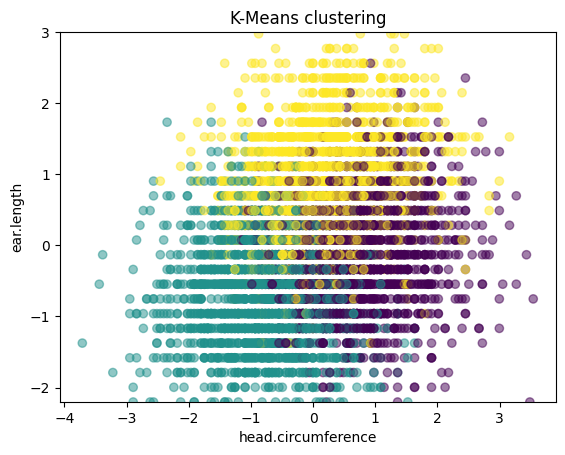

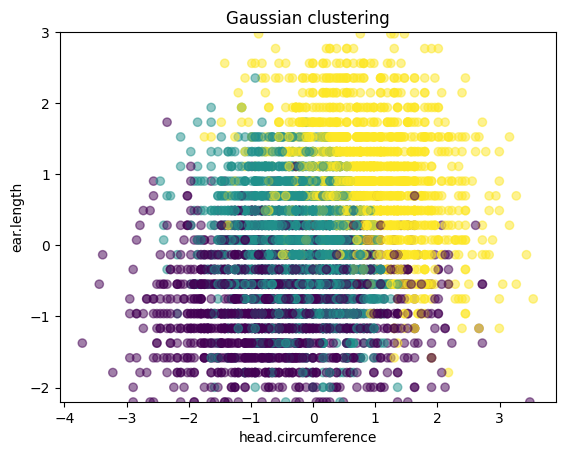

In [40]:
## Create Clustering model
km_model = KMeansClustering(n_clusters=3)
gc_model = GaussianClustering(n_clusters=3, random_state=101010)

## Run the model(s) on the data
km_predicted = km_model.fit_predict(ansur_features)
gc_predicted = gc_model.fit_predict(ansur_features)
## print(km_predicted)
## print(gc_predicted)

## Check errors
print("KMeans objective score:", km_model.score(ansur_features.values))
print("Gaussian likelihood score:", gc_model.score(ansur_features.values))
print("KMeans distance score:", km_model.distance_score())
print("Gaussian distance score:", gc_model.distance_score())
print("KMeans balance score:", km_model.balance_score())
print("Gaussian balance score:", gc_model.balance_score())

## Plot clusters as function of 2 or 3 variables
ansur_features_cov = ansur_features.cov()
labels = ["head.circumference", "ear.length"]
clusters = km_predicted["clusters"]
gc_clusters = gc_predicted["clusters"]

def plot_clusters(ansur_features, labels, clusters, title):
  xl, yl = labels[:2]
  x = ansur_features[xl]
  y = ansur_features[yl]

  plt.scatter(x, y, c=clusters, marker='o', linestyle='', alpha=0.5)
  plt.title(f"{title} clustering")
  plt.xlabel(xl)
  plt.ylabel(yl)
  plt.ylim([-2.2, 3])
  plt.show()

plot_clusters(ansur_features, labels, clusters, "K-Means")

def plot_clusters(ansur_features, labels, gc_clusters, title):
  xl, yl = labels[:2]
  x = ansur_features[xl]
  y = ansur_features[yl]

  plt.scatter(x, y, c=gc_clusters, marker='o', linestyle='', alpha=0.5)
  plt.title(f"{title} clustering")
  plt.xlabel(xl)
  plt.ylabel(yl)
  plt.ylim([-2.2, 3])
  plt.show()

plot_clusters(ansur_features, labels, gc_clusters, "Gaussian")


### Interpretation

<span style="color:hotpink;">
Which clustering algorithm did you choose?<br>
Did you try a different one?<br>
Do the clusters make sense ? Do they look balanced ?
</span>

<span style="color:hotpink;">I tried both K-mean and Gaussian clustering. K-mean seem to perform better in terms of both balance and distance, with a balance score of 0.966.</span>

## Figure out how many cluster

Experiment with the number of clusters to see if the initial choice makes sense.

The [WK08](https://github.com/PSAM-5020-2025S-A/WK08) notebook had a for loop that can be used to plot errors versus number of clusters.

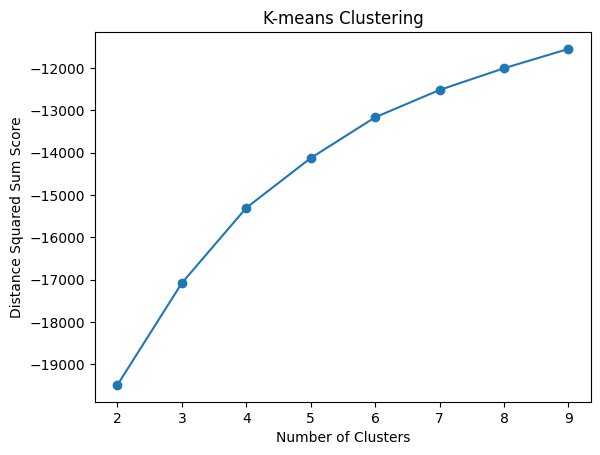

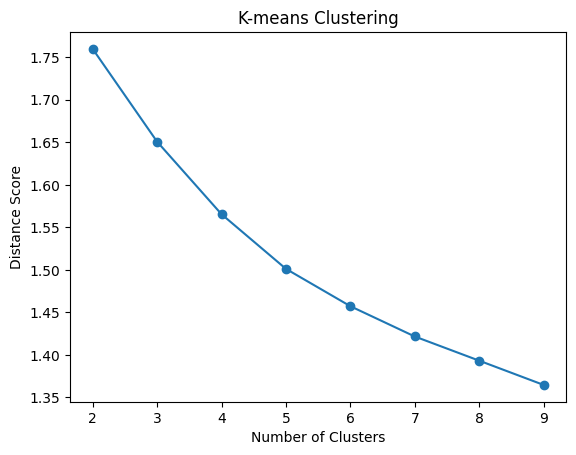

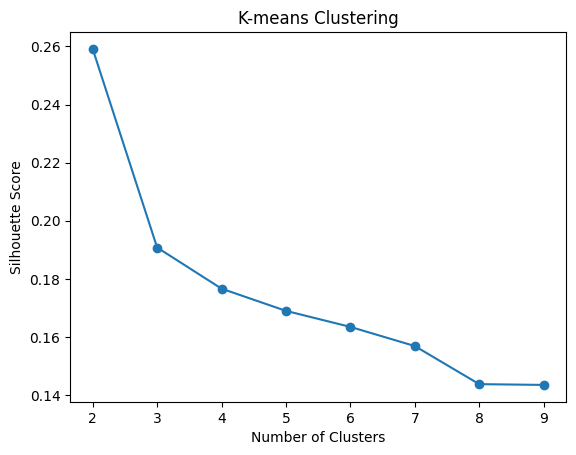

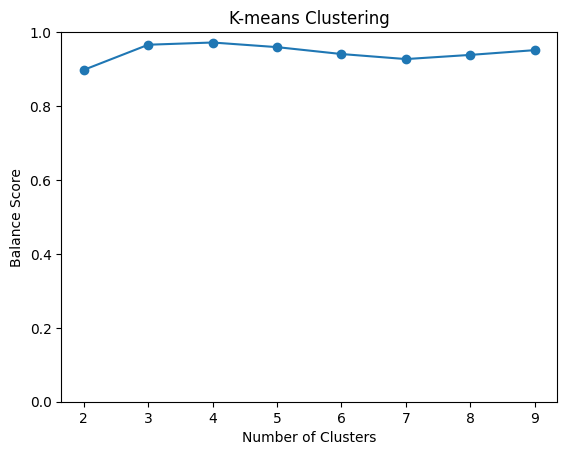

In [41]:
## Plot errors and pick how many cluster

# try 2 - 10 clusters for K-Means Clustering
num_clusters = list(range(2,10))

# collect distance, silhouette and balance scores
score_scores = []
distance_scores = []
silhouette_scores = []
balance_scores = []

# get distance, likelihood and balance for different clustering sizes
for n in num_clusters:
  mm = KMeansClustering(n_clusters=n)
  mm.fit_predict(ansur_features)
  score_scores.append(mm.score(ansur_features.values))
  distance_scores.append(mm.distance_score())
  silhouette_scores.append(mm.silhouette_score())
  balance_scores.append(mm.balance_score())

# plot scores as function of number of clusters
plt.plot(num_clusters, score_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Squared Sum Score")
plt.title("K-means Clustering")
# plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, distance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Score")
plt.title("K-means Clustering")
# plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("K-means Clustering")
# plt.ylim([-1, 1])
plt.show()

plt.plot(num_clusters, balance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Score")
plt.title("K-means Clustering")
plt.ylim([0, 1])
plt.show()

### Interpretation

<span style="color:hotpink;">
Based on the graphs of errors versus number of clusters, does it look like we should change the initial number of clusters ?<br>
How many clusters should we use ? Why ?
</span>

<span style="color:hotpink;">I would use 2 clusters. Even though balance store remains relatively stable across different numbers of clusters, distance and silhouette scores are negatively correlated with number of clusters.</span>

### Revise Number of Clusters.

Re-run with the new number of clusters and plot the data in $2D$ or $3D$.

This can be the same graph as above.

KMeans objective score: -19486.66851890531
KMeans distance score: 1.7599021742033603
KMeans balance score: 0.8985714285714286
KMeans silhouette score: 0.2591433616802908


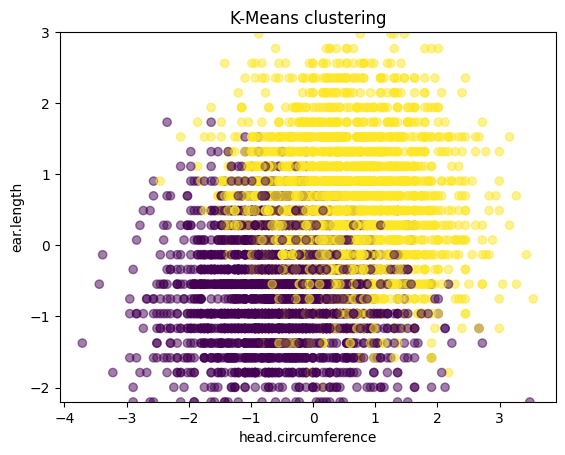

In [43]:
## Re-run clustering with final number of clusters
km_model = KMeansClustering(n_clusters=2)
## Run the model on the training data
km_predicted = km_model.fit_predict(ansur_features)

## Check errors
print("KMeans objective score:", km_model.score(ansur_features.values))
print("KMeans distance score:", km_model.distance_score())
print("KMeans balance score:", km_model.balance_score())
print("KMeans silhouette score:", km_model.silhouette_score())

## Plot in 3D
ansur_features_cov = ansur_features.cov()
labels = ["head.circumference", "ear.length"]
clusters = km_predicted["clusters"]
gc_clusters = gc_predicted["clusters"]

def plot_clusters(ansur_features, labels, clusters, title):
  xl, yl = labels[:2]
  x = ansur_features[xl]
  y = ansur_features[yl]

  plt.scatter(x, y, c=clusters, marker='o', linestyle='', alpha=0.5)
  plt.title(f"{title} clustering")
  plt.xlabel(xl)
  plt.ylabel(yl)
  plt.ylim([-2.2, 3])
  plt.show()

plot_clusters(ansur_features, labels, clusters, "K-Means")

### Interpretation

<span style="color:hotpink;">
Do these look better than the original number of clusters?
</span>

<span style="color:hotpink;">Two clusters seem relatively euqally spread out. While 2 clusters have a lower balance score than 3 clusters, the former has a higher distance score and silhouette score. So overall 2 clusters is better than 3 clusters.</span>

## Image Organization

We have a dataset of about $600$ flower images that we might want to classify by species... eventually.

What we want to do first is take a look at all of the images and see what kind of images we have, what kind of colors our flowers have and see if there's any other visual information that could help us classify these images later.

We'll see how to use clustering and distances to organize our images by color to create a visualization that we cna use to get to know our dataset.

### Load Dataset

The following cell downloads the dataset:

In [3]:
!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/flowers.tar.gz | tar xz

Then, we can take a look at a few of the images:

In [4]:
IMG_DIR = "./data/image/flowers"

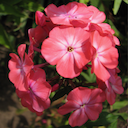

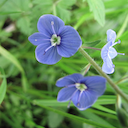

In [5]:
display(PImage.open(f"{IMG_DIR}/00_001.png"))
display(PImage.open(f"{IMG_DIR}/15_001.png"))

### Find Representative Colors

The overall process for organizing our images by color will be something like this:

1. Iterate over all files in the `data/image/flowers` directory, open each image file and treat it as a dataset
   1. Load image into a `DataFrame` where each pixel is a row and R,G,B values are columns/features
   2. Cluster into $2$ - $16$ colors
   3. Pick $3$ or $4$ representative colors
   4. Store image filenames and their representative colors in a Python object
2. Once all images have been processed we can order our dataset by different color characteristics: white to black, red to blue, hue value, brightness

### One Image

Let's step through the process of getting representative colors for one image, and then we can repeat this in a loop to process all of the flower images.

#### Open Image

The `PIL` library does all the work here:

In [6]:
# Open image
fname = "00_001.png"
pimg = PImage.open(f"{IMG_DIR}/{fname}").convert("RGB")

#### Put into `DataFrame`

We get the pixels and make a dataset/`DataFrame` out of them:

In [7]:
# Load into DataFrame
pxs = get_pixels(pimg)
pxs_df = pd.DataFrame(pxs, columns=["R", "G", "B"])

#### Cluster colors

Create a clustering object, cluster colors into $8$ clusters with `fit_predict()` and take a look at our color palette (`cluster_centers_`):

       clusters
0             4
1             4
2             4
3             4
4             4
...         ...
16379         7
16380         1
16381         1
16382         4
16383         7

[16384 rows x 1 columns]
[[244, 121, 144], [56, 49, 28], [176, 52, 72], [247, 171, 198], [20, 22, 14], [124, 33, 44], [222, 83, 104], [93, 93, 48]]


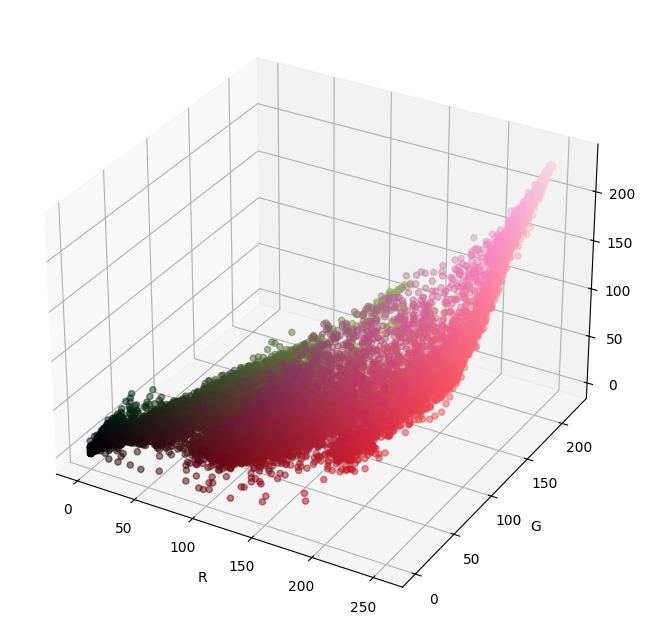

In [8]:
# TODO: Create Clustering object
km_model = KMeansClustering(n_clusters=8)
# TODO: Cluster by color
km_predicted = km_model.fit_predict(pxs_df)
print(km_predicted)
# TODO: Take a look at the color palette (cluster_centers_)
km_model.cluster_centers_
color_centers = [[round(r), round(g), round(b)] for r,g,b in km_model.cluster_centers_]
print(color_centers)

c = [(r/255, g/255, b/255) for r,g,b in get_pixels(pimg)]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(pxs_df["R"], pxs_df["G"], pxs_df["B"], c=c, marker='o', linestyle='', alpha=0.5)
ax.set_xlabel("R")
ax.set_ylabel("G")
ax.set_zlabel("B")
plt.show()


#### Checkpoint

<span style="color:hotpink;">
Does anything stand out about the colors?
</span>

<span style="color:hotpink;">A lot of green and red/pink (flowers lol...)</span>

#### Reconstruct Image

Since we're only doing one image for now, let's take a look at the clustering result.

This is like in the lecture notebook. We'll start with an empty pixel array and as we iterate through the `DataFrame` of cluster ids we append the corresponding colors to it.

In [41]:
# TODO: create empty pixel array
pxs_post = []

# TODO: iterate through resulting list of cluster ids # TODO: append corresponding color value to pixel array
for gidx in km_predicted["clusters"]:
  pxs_post.append(color_centers[gidx])

Now we can look at the image. If this next cell gives errors about using `float` values in images, just make sure the pixel values that are being appended above are all whole number `int` values.

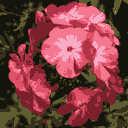

In [10]:
display(make_image(pxs_post, width=pimg.size[0]))

#### Checkpoint

<span style="color:hotpink;">
How does changing the number of clusters affect the resulting image?<br>Try some lower values like <code>2</code> and <code>4</code>, and also some higher ones like <code>12</code> and <code>16</code>. Take a look at a different image.
</span>

<span style="color:hotpink;">More clusters result in a more vivid or life like floral image with different hues, whereas a lower number of cluster shows less variaton in colors and more abstracted. </span>

#### Pick Colors

Ok, we have some representative colors for our images. We should keep more than one color, but maybe we don't have to keep $12$.

We can use the `value_counts()` function of our `DataFrame` to see how many pixels are represented by each of our cluster colors:

In [ ]:
# cluster ids and pixel counts, ordered by descending counts
##ccounts = px_clusters_df["clusters"].value_counts()
ccounts = km_predicted["clusters"].value_counts()
display(ccounts[:4].index)

Index([4, 5, 1, 0], dtype='int32', name='clusters')

Since what we are really trying to do here is get some information about the colors of the flowers present in our images, and given the type of images we have, we can start by assuming that the flower colors will be in the top-$4$ clusters returned by `value_counts()`.

We can revisit this assumption later. We might also want to add some filters here to ignore sky and vegetation colors (blues and greens) and only keep flower colors.

For now, let's just grab the top-$4$ colors from `value_counts()`, remembering we want to keep their rounded `int` values and not the default `float` values in `cluster_centers_`.

In [55]:
# Object to keep colors for each file
file_info = {
  "filename": fname,
  "colors": []
}

# TODO: go through ccounts.index and get corresponding colors for each clusters 
chosen_clusters = ccounts[:4].index

# # TODO: add top-4 colors to the "colors" key of the file_color_info object
for i in chosen_clusters:
    rgb = km_model.cluster_centers_[i]
    rgb_int = [round(x) for x in rgb]
    file_info["colors"].append(rgb_int)

display(file_info)

{'filename': '00_010.png',
 'colors': [[107, 117, 76], [28, 40, 21], [179, 178, 179], [46, 66, 34]]}

In [13]:
display(file_info)

{'filename': '00_001.png',
 'colors': [[93, 93, 48], [176, 52, 72], [244, 121, 144], [56, 49, 28]]}

#### Checkpoint

<span style="color:hotpink;">
Why might we want to cluster into <code>8</code> or even <code>12</code> colors when in the end we're only keeping <code>4</code>?
</span>

<span style="color:hotpink;">So that we can pick the top four?</span>

### Iterate and Cluster

We've processed one image, now let's process $600$... for-loops FTW!

We'll need to loop through all of the images in our directory and repeat the process above for each one of them.

We can create a function that takes a filename as input and returns the top-$4$ colors for that image, or... we can just put all of the clustering logic in the body of a for loop. Whichever is easiest.

Let's get started.

In [14]:
# list of all files in the flowers directory
flower_files = sorted([f for f in listdir(IMG_DIR) if f.endswith(".png")])

Here's the loop. In the end we want our `file_colors` list to have objects that have a filename and $4$ colors associated with each filename. Something like:

```py
[
  {
    "filename": "00_001.png",
    "colors": [[12,44,12], [112,144,62],  [12,84,112], [212,144,102]]
  },
  {
    "filename": "00_002.png",
    "colors": [[22,24,28], [112,114,122], [128,200,2], [250,240,230]]
  },
  ...
]
```

This can take a while to run (up to a minute for $600$ images). We can use slicing to test our logic on a subset of `flower_files` before processing all $600$ images.

In [ ]:
# List to keep colors for each file
file_colors = []

# TODO: get colors for each image
for fname in flower_files[:20]:
    pimg = PImage.open(f"{IMG_DIR}/{fname}").convert("RGB")
    pxs = get_pixels(pimg)
    pxs_df = pd.DataFrame(pxs, columns=["R", "G", "B"])

    km_model = KMeansClustering(n_clusters=8)
    km_model.fit(pxs_df)

    counts = pd.Series(km_model.labels_).value_counts()
    top_clusters = counts.index[:4]

    colors = []
    for i in top_clusters:
        rgb = km_model.cluster_centers_[i]
        rgb_int = [round(x) for x in rgb]
        colors.append(rgb_int)

    file_colors.append({
        "filename": fname,
        "colors": colors
    })

display(file_colors[:4])

[{'filename': '00_001.png',
  'colors': [[21, 22, 14], [124, 33, 44], [56, 49, 28], [244, 120, 143]]},
 {'filename': '00_002.png',
  'colors': [[25, 29, 20], [165, 69, 157], [187, 94, 188], [125, 52, 110]]},
 {'filename': '00_003.png',
  'colors': [[212, 47, 85], [234, 72, 111], [185, 25, 60], [246, 100, 147]]},
 {'filename': '00_004.png',
  'colors': [[53, 64, 35], [29, 36, 21], [237, 74, 112], [245, 97, 142]]}]

#### Order Images (almost)

We have a list with objects that keep track of filenames and representative colors. We could create a `DataFrame` or csv dataset with these, but let's go ahead and just use this directly in this format.

What we want to do is re-order our list of objects, but using a `key` function that takes each object's colors into consideration.

We'll look into how to do this dynamically later, but for now let's order our images by something like _brightness_. It's _like_ brightness because what we'll do is measure how close each image is to the white color `(255,255,255)`.

We'll need some helper functions first:

- `color_distance()`: takes $2$ colors and returns the distance between them
- `min_color_distance()`: given a reference color and a list of colors, returns the distance between the reference color and the closest color in the list

In [33]:
# TODO: implement function that returns distance between two colors
def color_distance(c0, c1):
  # TODO: add logic here
  return ((c0[0] - c1[0])**2 +
            (c0[1] - c1[1])**2 +
            (c0[2] - c1[2])**2) ** 0.5 # TODO: Change this

Some tests for the `color_distance()` function:

In [22]:
# Some tests for the color_distance() function
print(color_distance([0,0,0], [255,255,255]), "should be", 255*3**.5)
print(color_distance([0,100,0], [100,100,0]), "should be", 100)
print(color_distance([55,222,120], [91,51,192]), "should be", 189)
print(color_distance([147,207,246], [87,57,50]), "should be", 254)
print(color_distance([12,250,126], [112,10,195]), "should be", 269)
print(color_distance([106,71,61], [105,136,100]), "should be", 75.81)

441.6729559300637 should be 441.67295593006367
100.0 should be 100
189.0 should be 189
254.0 should be 254
269.0 should be 269
75.80897044545586 should be 75.81


In [23]:
# TODO: implement function that returns minimum distance between a reference color and colors from a list
def min_color_distance(ref_color, color_list):
  min_dist = 100000000000000
  for color in color_list:
      dist = color_distance(ref_color, color)
      if dist < min_dist:
            min_dist = dist
  return min_dist

Three tests for the `min_color_distance()` function:

In [24]:
# Some tests for the color_distance() function
print(min_color_distance([0,0,0], [[255,255,255],[0,100,0],[100,100,0],[58,58,58]]), "should be", 100)
print(min_color_distance([0,0,0], [[255,255,255],[0,100,0],[100,100,0],[58,57,58]]), "should be", 99.88)
print(min_color_distance([91,51,192], [[147,207,246],[87,57,50],[12,250,126],[112,10,195]]), "should be", 46.16)

100.0 should be 100
99.88493379884676 should be 99.88
46.16275555033516 should be 46.16


#### Order Images (for real now)

Alright. We have a function that can be used to order our images by their distance to a given color.

Let's order our images by how close they are to the brightest color `(255,255,255)`. We'll define a `key` function that, given an object from our `file_colors` list, returns how close that image is to the color `(255,255,255)`.

In [34]:
# TODO: implement function that returns how close our image is to the color white
def by_bright_dist(A):
  # TODO: add logic here
  return min_color_distance([255, 255, 255], file_info["colors"]) # TODO: Change this

Order the list and write out a `JSON` file with the image order.

In [ ]:
file_colors_sorted = sorted(file_colors, key=by_bright_dist)

In [ ]:
files_sorted = [A["filename"] for A in file_colors_sorted]

with open("./data/flower_order.json", "w") as ofp:
  json.dump(files_sorted, ofp)

### Viewing Results

We can check the results by running a webserver and looking at a simple web page that orders the images according to the resulting `JSON` file from above.

We'll make use of the [`Live Server`](https://marketplace.visualstudio.com/items?itemName=ritwickdey.LiveServer) VSCode extension.

We can start the server by clicking on the "_Go Live_" button towards the right hand side of the bar at the very bottom of our text editor:

<img src="./imgs/go_live.jpg" width="600px">

Clicking the "_Go Live_" button in Codespace should open up a new tab with a plain html navigation view of our repository. Clicking on the `html/` directory should open up a web page with all of the flower images. If not, you can use your Codespace url to try to find the web server address.

If your Codespace url is something like:<br>`https://mango-special-giggle-v6v7asd322f7p6.github.dev/`

Then, the webserver should be running at:<br>`https://mango-special-giggle-v6v7asd322f7p6-5500.app.github.dev/`

### Review, Contemplate, Experiment

Yes, images with white parts are towards the beginning, but the images towards the end aren't necessarily the ones with dark flowers, but are the ones that have all of their representative colors farthest away from white `(255,255,255)`, which includes very saturated colors/images.

A couple of interesting experiments here could be:
- Decrease the number of clusters or the number of colors kept after clustering.
- Use different colors as the reference for the distance functions. For example, create `by_gold_dist()` or `by_purple_dist()` functions to use as the `key` for sorting.
- Order the list of cluster colors by [hue](https://stackoverflow.com/questions/23090019/fastest-formula-to-get-hue-from-rgb). This can be a bit tricky to get right because some colors, like white, black and gray, don't have a unique value for hue, but depend on other aspects of the color, like saturation and lightness, to be well-defined.

       clusters
0             0
1             0
2             0
3             0
4             0
...         ...
16379         1
16380         1
16381         1
16382         1
16383         1

[16384 rows x 1 columns]
[[168, 168, 164], [54, 70, 40]]


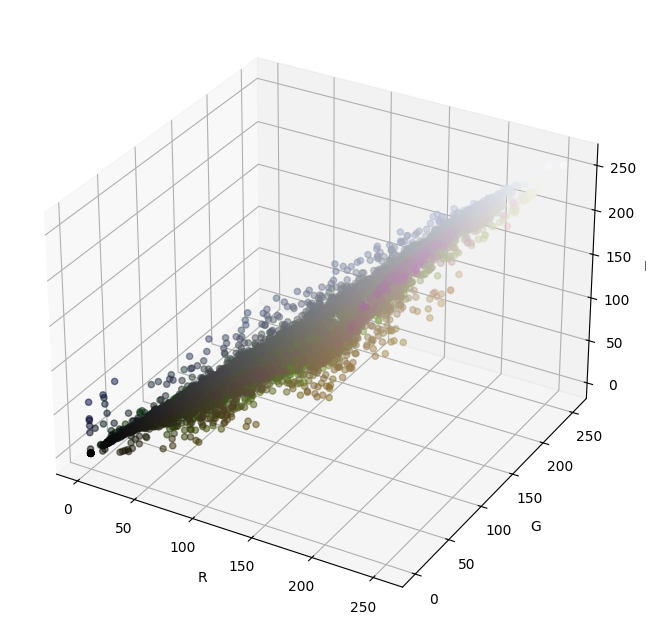

{'filename': '00_010.png', 'colors': [[54, 70, 40], [168, 168, 164]]}

In [ ]:
km_model = KMeansClustering(n_clusters=2)
km_predicted = km_model.fit_predict(pxs_df)
print(km_predicted)
km_model.cluster_centers_
color_centers = [[round(r), round(g), round(b)] for r,g,b in km_model.cluster_centers_]
print(color_centers)

c = [(r/255, g/255, b/255) for r,g,b in get_pixels(pimg)]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(pxs_df["R"], pxs_df["G"], pxs_df["B"], c=c, marker='o', linestyle='', alpha=0.5)
ax.set_xlabel("R")
ax.set_ylabel("G")
ax.set_zlabel("B")
plt.show()

ccounts = km_predicted["clusters"].value_counts()

file_info = {
  "filename": fname,
  "colors": []
}

chosen_clusters = ccounts[:4].index

for i in chosen_clusters:
    rgb = km_model.cluster_centers_[i]
    rgb_int = [round(x) for x in rgb]
    file_info["colors"].append(rgb_int)

display(file_info)

file_colors_sorted = sorted(file_colors, key=by_bright_dist)
files_sorted = [A["filename"] for A in file_colors_sorted]

with open("./data/flower_order.json", "w") as ofp:
  json.dump(files_sorted, ofp)


### Interpretation

<span style="color:hotpink;">
What did you try ? What happened ?
</span>

<span style="color:hotpink;">I reduced number of clusters down to 2 and did not observe changes in the sequencing.</span>

### Conclusion

It's challenging to define a set of functions that will perfectly order our flowers by color without first having to define very specific color values for filtering and corner-cases. At a high-level, we can imagine that this is because color is a $3$-dimensional value, and we're using it to organize our images into a single-dimensional order.

The beginning of our ordering is usually pretty good, since there's only one way for a color to be _close_ to our reference color, but the ordering gets less consistent towards the end because there are many different ways for a color to be _far_ from the reference color.

Next week we'll see a very powerful technique that, amongst other things, will help us get around this kind of "_dimensionality mismatch_".